## Libs import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Task 1 - EDA

### Data reading

In [3]:
data1 = pd.read_csv('data/data1.csv', index_col='DateTime')
data2 = pd.read_csv('data/data2.csv', index_col='DateTime')

### Data analysis

Проверка данных на пропуски и дубликаты

In [4]:
# Проверка на пропущенные значения
missing_values = data1.isnull().sum().sum()

# Проверка на дубликаты
duplicates = data1.reset_index().duplicated().sum()

# Вывод результатов проверки
print(f"Пропущенные значения data1: {missing_values}")
print(f"Количество дубликатов data1: {duplicates}")
print()

# Проверка на пропущенные значения
missing_values = data2.isnull().sum().sum()

# Проверка на дубликаты
duplicates = data2.reset_index().duplicated().sum()

# Вывод результатов проверки
print(f"Пропущенные значения data2: {missing_values}")
print(f"Количество дубликатов data2: {duplicates}")

Пропущенные значения data1: 0
Количество дубликатов data1: 168

Пропущенные значения data2: 0
Количество дубликатов data2: 168


В условии сказано, что значения rho должны лежать в пределах [1.0, 2.5], предлагается пока не обращать внимание на несоблюдение этого условия.

In [5]:
# data1 = data1[(data1['ro1'] >= 1.0) & (data1['ro1'] <= 2.5) & \
#         (data1['ro2'] >= 1.0) & (data1['ro2'] <= 2.5) & \
#         (data1['ro3'] >= 1.0) & (data1['ro3'] <= 2.5) & \
#         (data1['ro4'] >= 1.0) & (data1['ro4'] <= 2.5)]
# data2 = data2[(data2['ro1'] >= 1.0) & (data2['ro1'] <= 2.5) & \
#         (data2['ro2'] >= 1.0) & (data2['ro2'] <= 2.5) & \
#         (data2['ro3'] >= 1.0) & (data2['ro3'] <= 2.5) & \
#         (data2['ro4'] >= 1.0) & (data2['ro4'] <= 2.5)]

data1.index = pd.to_datetime(data1.index)
data2.index = pd.to_datetime(data2.index)

Выведем количество данных, неудовлетворяющих условиям

In [6]:
data1[~((data2['ro1'] >= 1.0) & (data2['ro1'] <= 2.5) & \
      (data2['ro2'] >= 1.0) & (data2['ro2'] <= 2.5) & \
      (data2['ro3'] >= 1.0) & (data2['ro3'] <= 2.5) & \
      (data2['ro4'] >= 1.0) & (data2['ro4'] <= 2.5))].count().iloc[0], \
data2[~((data1['ro1'] >= 1.0) & (data1['ro1'] <= 2.5) & \
      (data1['ro2'] >= 1.0) & (data1['ro2'] <= 2.5) & \
      (data1['ro3'] >= 1.0) & (data1['ro3'] <= 2.5) & \
      (data1['ro4'] >= 1.0) & (data1['ro4'] <= 2.5))].count().iloc[0]

(282359, 282359)

Общее описание так себе выводить на "широких" фреймах, но по канону выведем

In [7]:
data1.describe()

,Ni1,S1,Fe3O41,Ni2,S2,Fe3O42,Ni3,S3,Fe3O43,Ni4,...,ro2,ro3,ro4,ro_final,ust1,ust2,ust3,ust4,v_final,level_final
count,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,...,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000
mean,5.477315,20.003626,1.951034,5.731805,17.743569,2.520591,7.547059,19.185887,2.681726,8.906555,...,1.699458,1.720863,1.873061,1.663788,17.495724,22.265632,27.880240,128.550099,134.460871,49.213927
std,1.174854,2.604641,0.765599,1.808937,3.004234,1.295176,1.334541,3.780063,1.232703,0.454001,...,0.478319,0.375284,0.384344,0.350396,14.590002,20.538308,20.696594,23.069860,83.669148,28.835602
min,3.660000,9.930000,0.200000,2.870000,7.970000,0.200000,4.130000,6.680000,0.300000,4.540000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.000000,0.000000,-1.000000
25%,4.690000,19.240000,1.500000,4.260000,16.460000,1.600000,6.480000,16.500000,2.100000,8.670000,...,1.227700,1.605000,1.749125,1.444900,0.000000,10.000000,10.000000,113.000000,9.000000,40.073300
50%,5.110000,20.400000,1.800000,5.110000,18.600000,2.000000,7.430000,18.800000,2.600000,8.900000,...,1.798000,1.791300,1.907450,1.841800,17.000000,14.000000,28.000000,125.000000,167.000000,56.605600
75%,5.950000,21.400000,2.200000,7.220000,19.600000,2.900000,8.450000,21.900000,3.500000,9.140000,...,2.038350,1.921450,2.127750,1.903700,26.000000,35.000000,44.000000,142.000000,191.000000,71.379700
max,9.600000,27.720000,6.200000,10.240000,29.540000,7.900000,10.890000,38.300000,8.700000,10.440000,...,2.997900,2.998100,2.995700,2.999800,81.000000,96.000000,96.000000,215.000000,285.000000,100.000000


Создадим словари для удобства:

In [8]:
columns_groups = {
  1: ['Ni1', 'S1', 'Fe3O41', 'ro1', 'ust1', 'ro_final', 'v_final', 'level_final'],
  2: ['Ni2', 'S2', 'Fe3O42', 'ro2', 'ust2', 'ro_final', 'v_final', 'level_final'],
  3: ['Ni3', 'S3', 'Fe3O43', 'ro3', 'ust3', 'ro_final', 'v_final', 'level_final'],
  4: ['Ni4', 'S4', 'Fe3O44', 'ro4', 'ust4', 'ro_final', 'v_final', 'level_final'],
}

columns_groups_no_final = {
  1: ['Ni1', 'S1', 'Fe3O41', 'ro1', 'ust1'],
  2: ['Ni2', 'S2', 'Fe3O42', 'ro2', 'ust2'],
  3: ['Ni3', 'S3', 'Fe3O43', 'ro3', 'ust3'],
  4: ['Ni4', 'S4', 'Fe3O44', 'ro4', 'ust4'],
}

columns_groups_entity = {
  1: ['Ni1', 'Ni2', 'Ni3', 'Ni4'],
  2: ['S1', 'S2', 'S3', 'S4'],
  3: ['ro1', 'ro2', 'ro3', 'ro4', 'ro_final'],
  4: ['Fe3O41', 'Fe3O42', 'Fe3O43', 'Fe3O44'],
  5: ['ust1', 'ust2', 'ust3', 'ust4'],
}

Формируем матрицы ковариаций для анализа предполагаемых линейных зависимостей в признаках

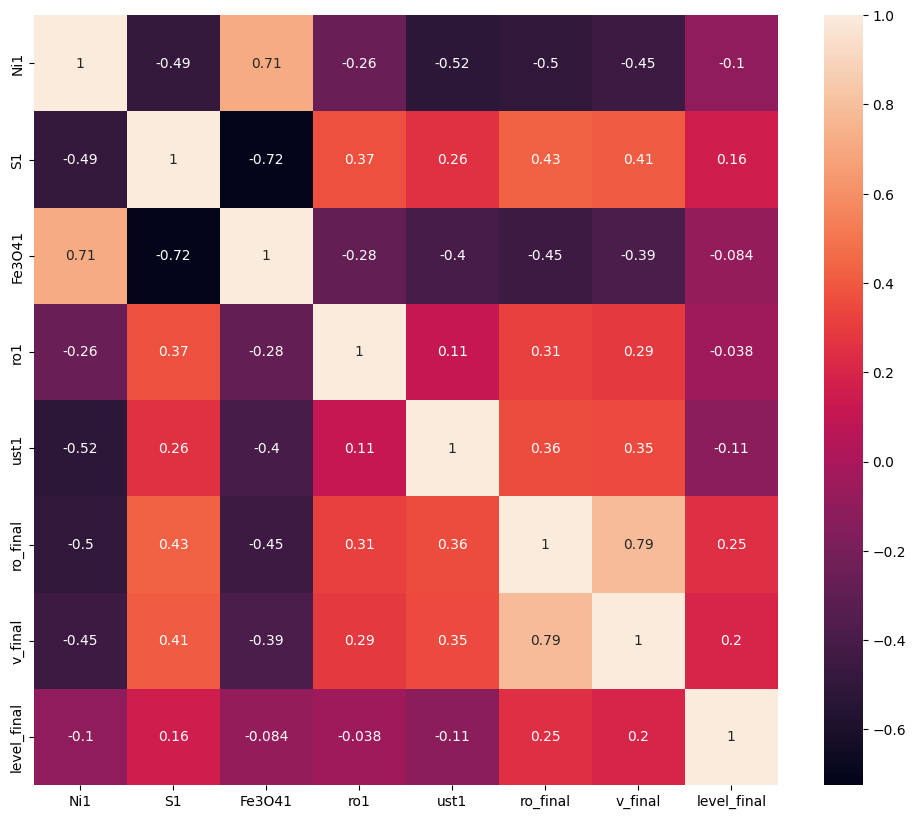

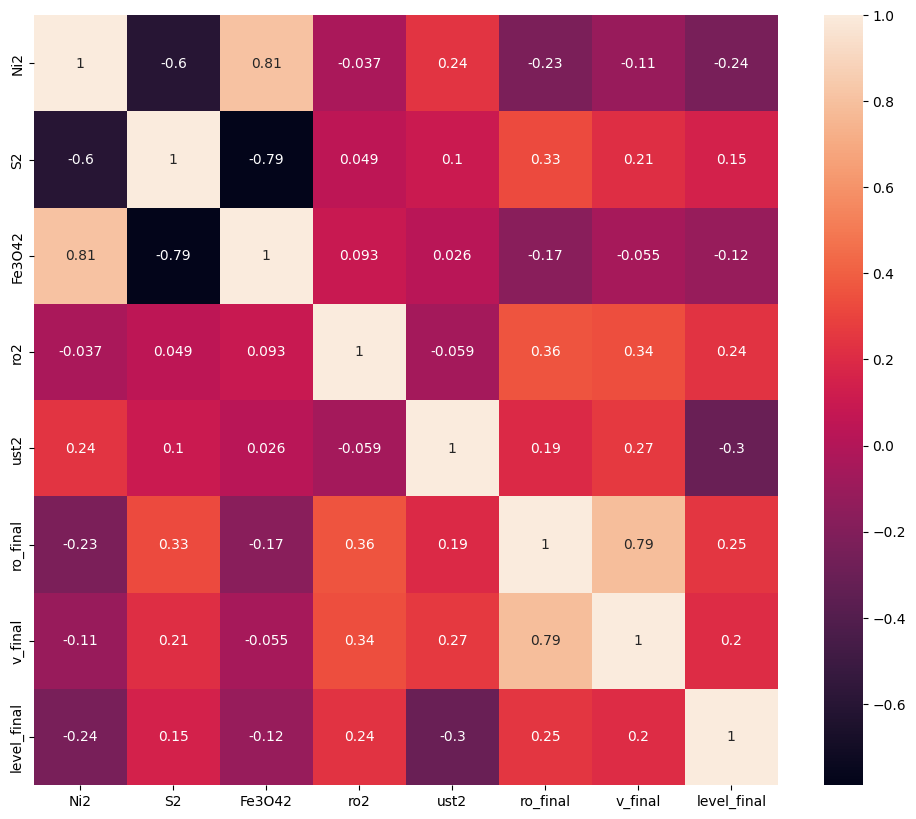

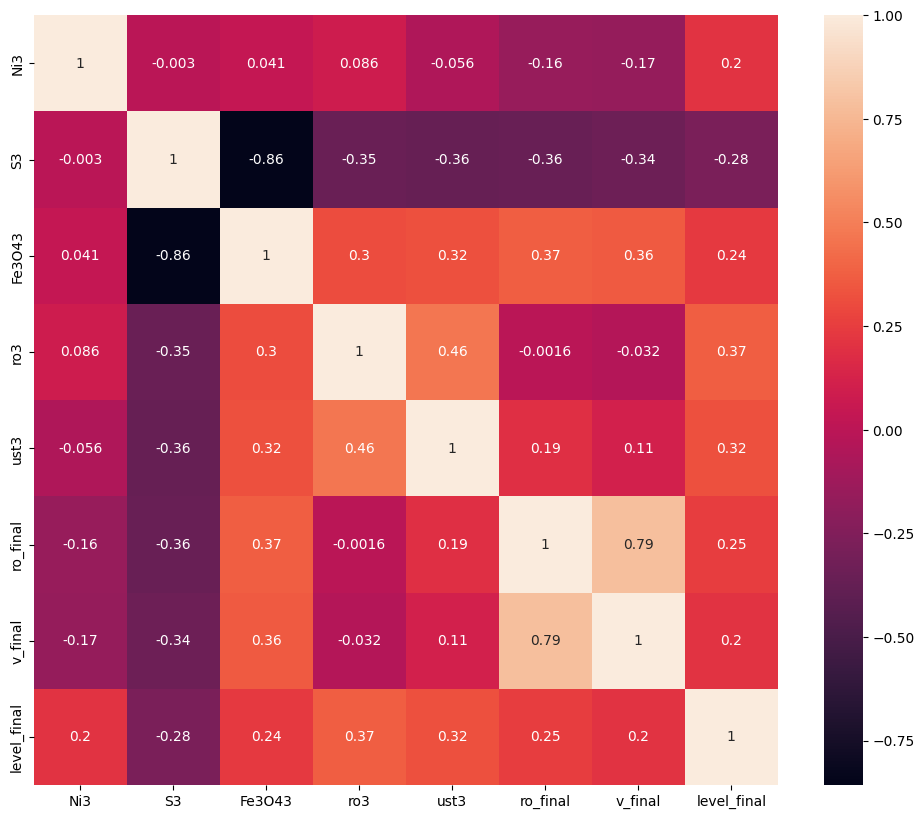

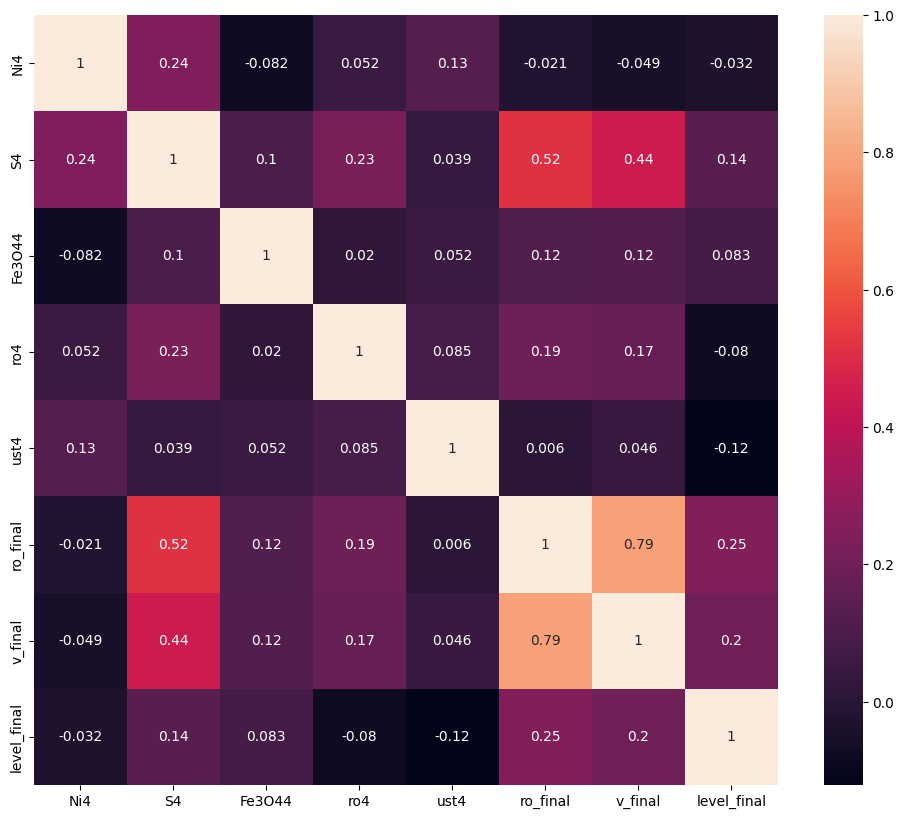

In [9]:
for col in columns_groups:
  plt.figure(figsize=(12,10))
  sns.heatmap(data1[columns_groups[col]].corr(), annot=True)
  plt.show()

Самый наглядный способ анализа - строим графики по группам

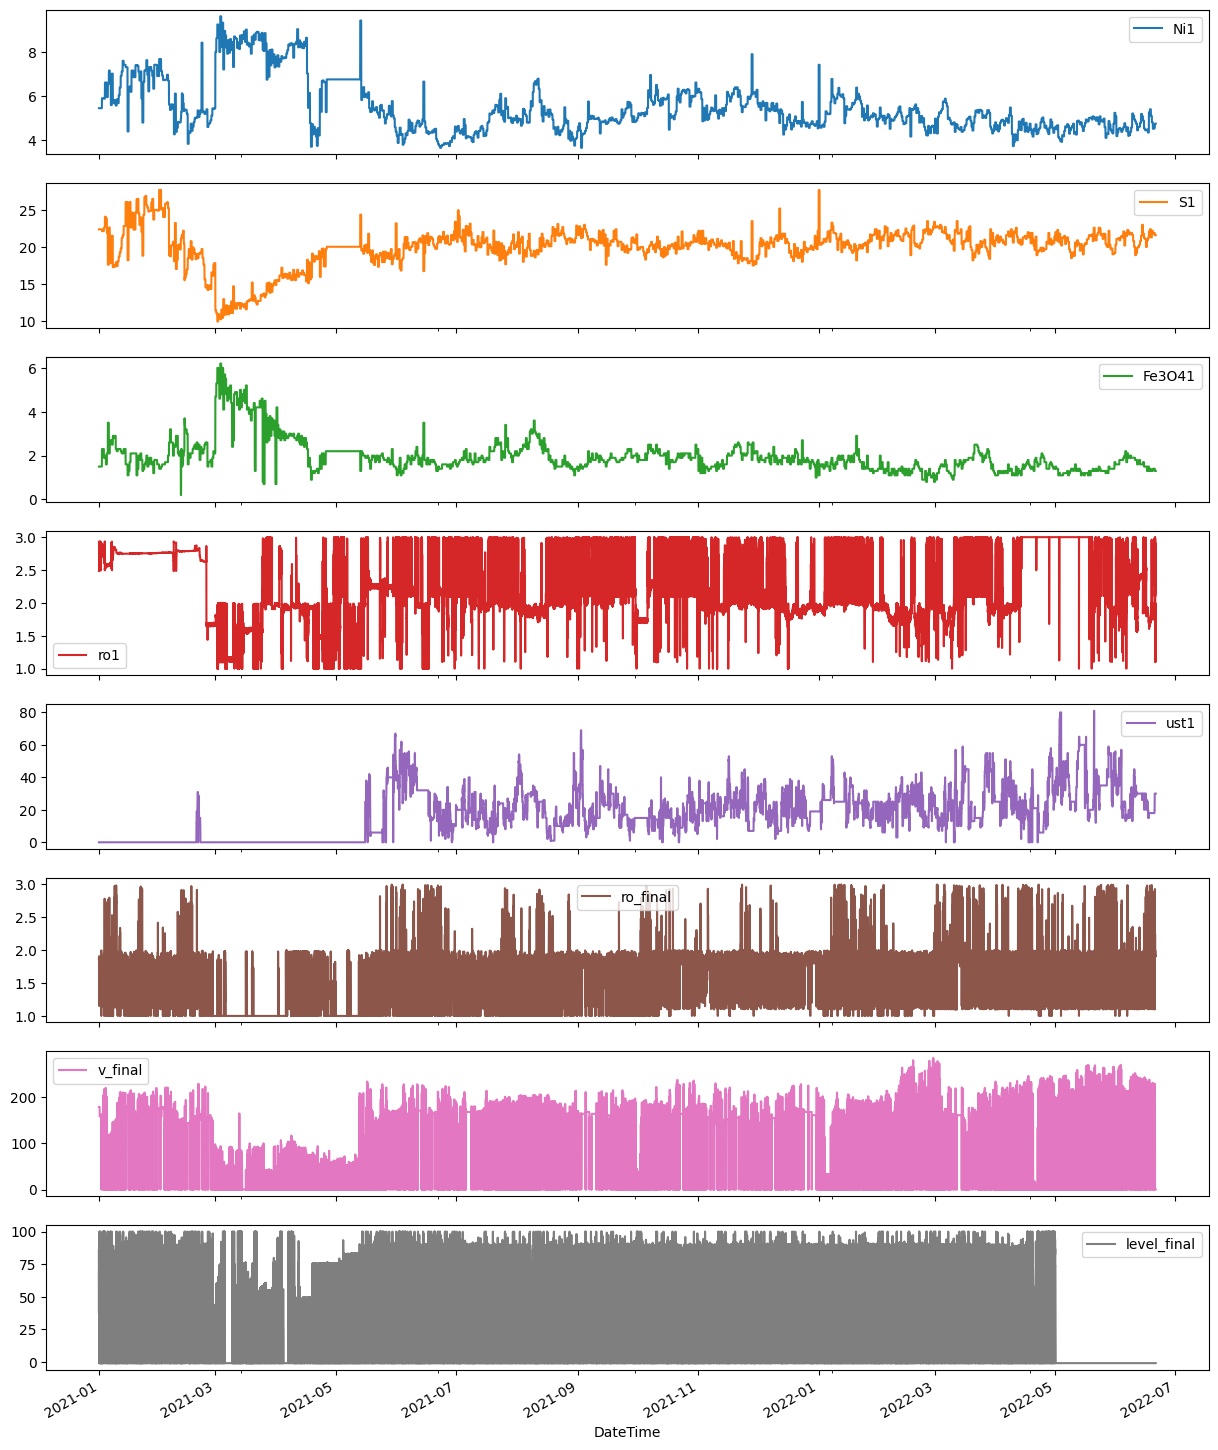

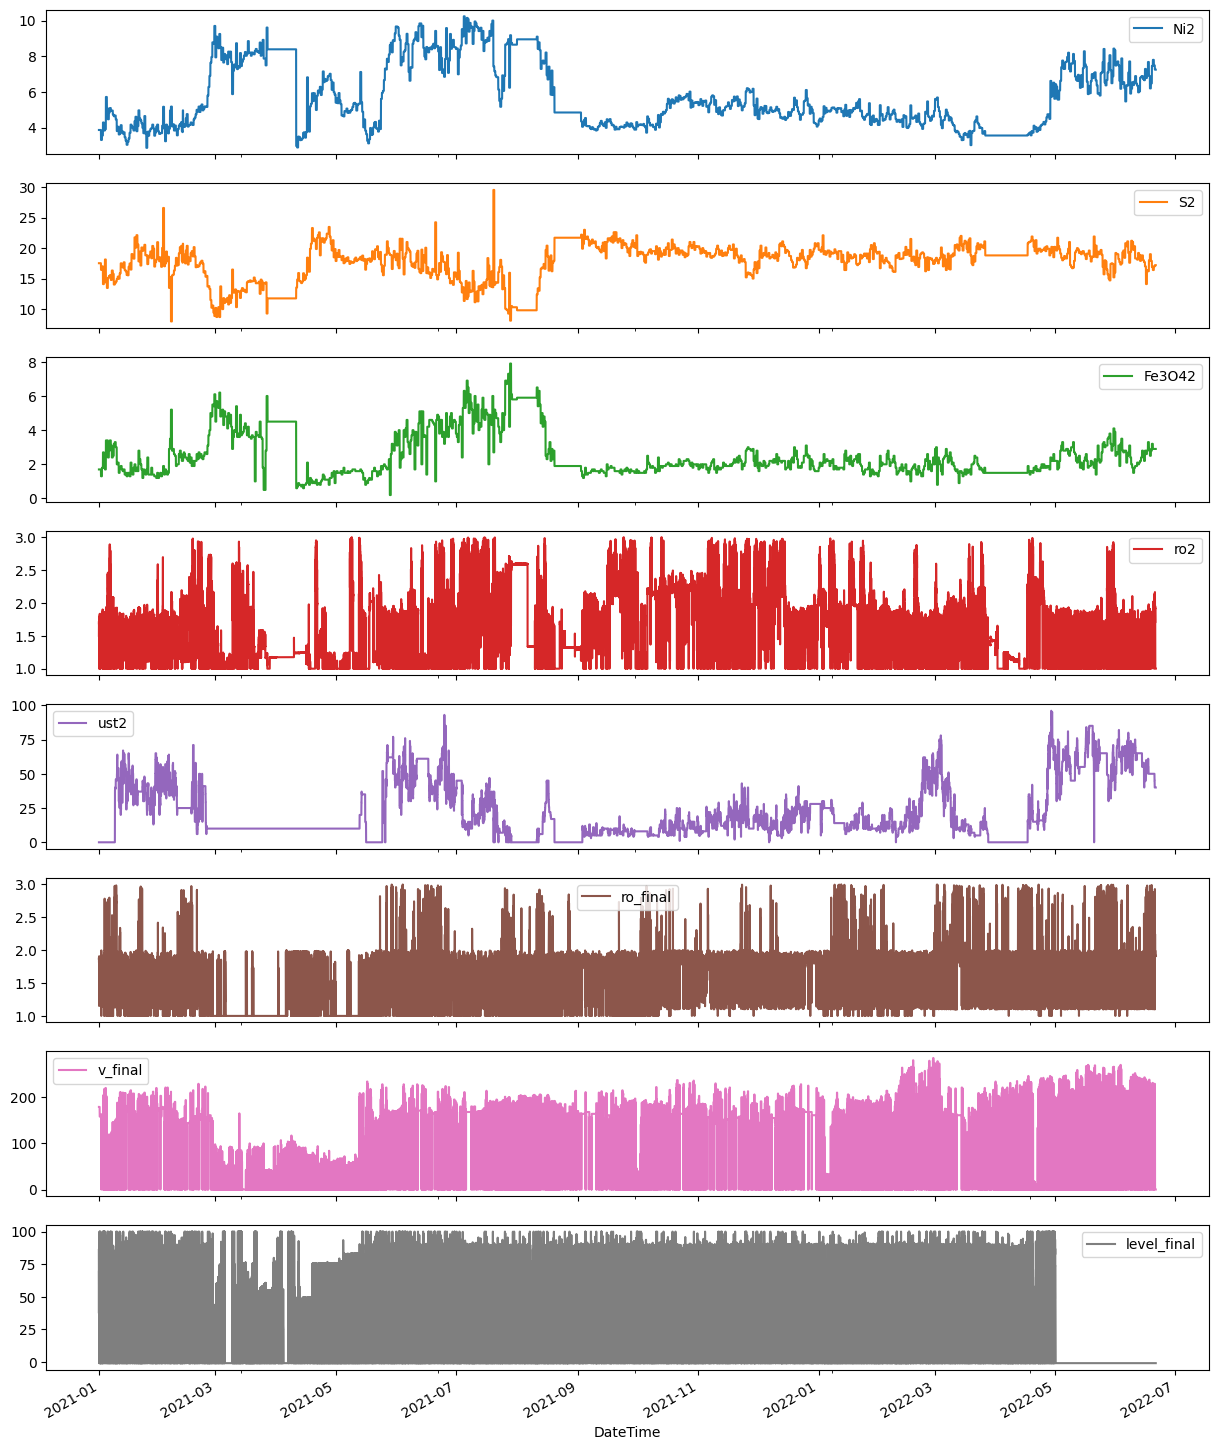

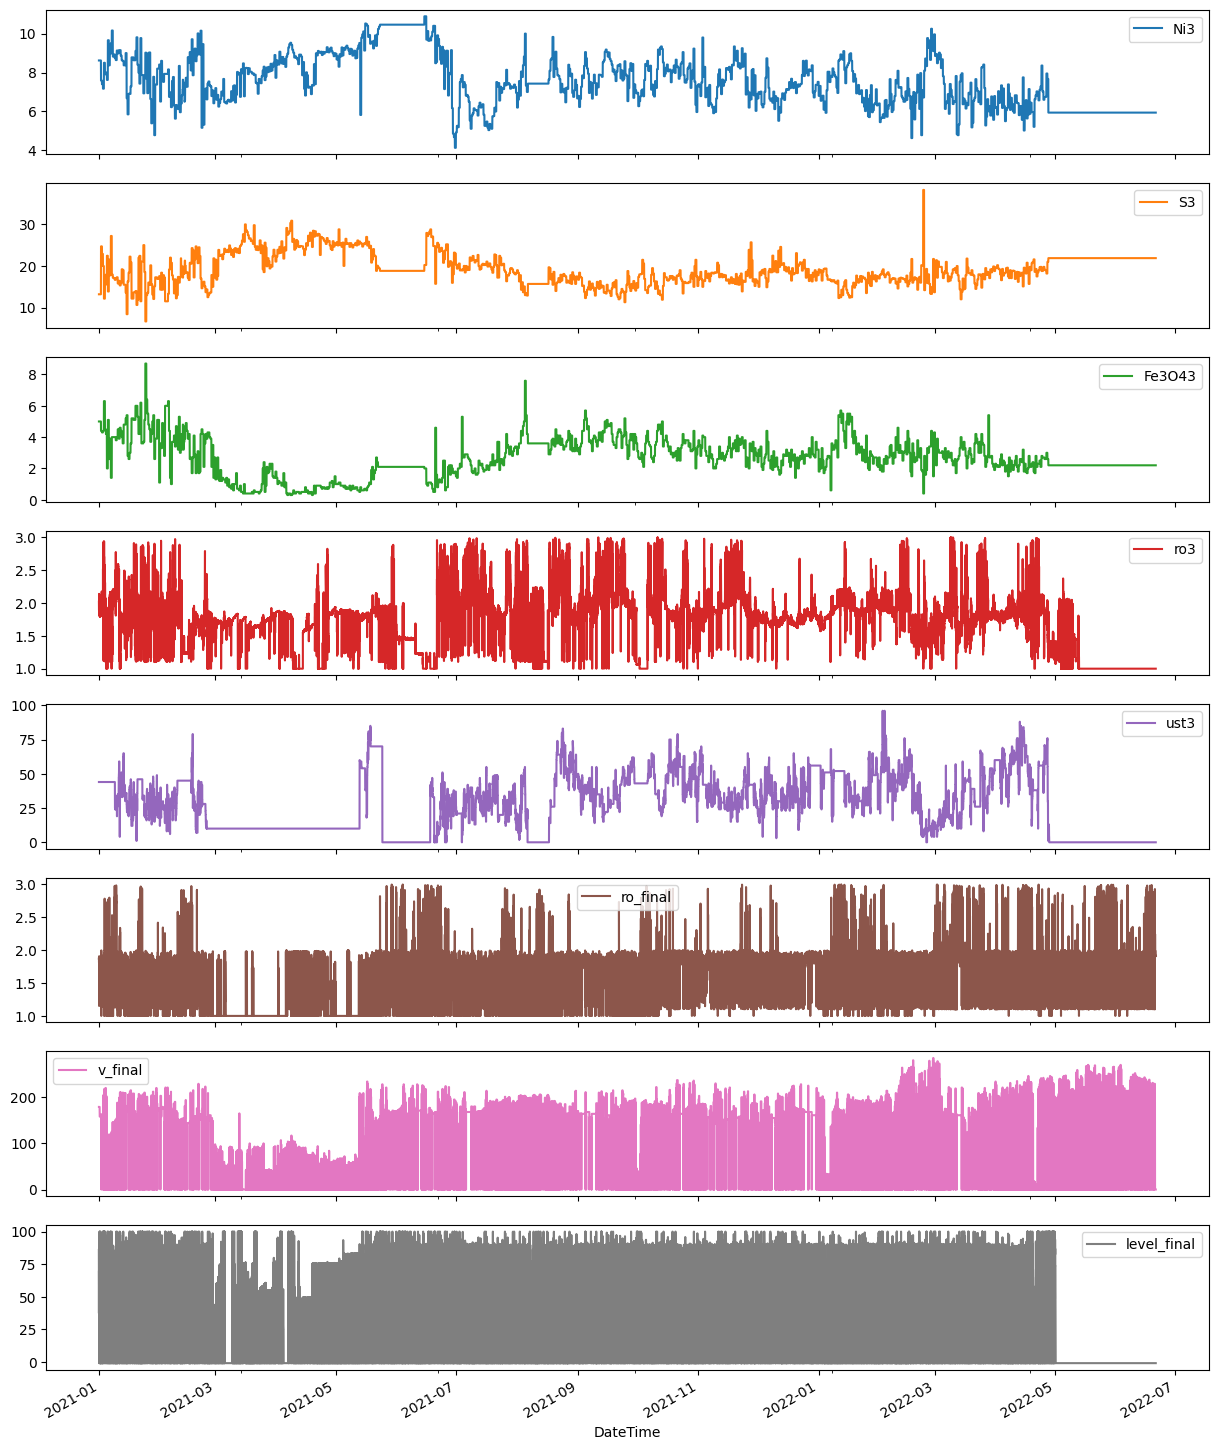

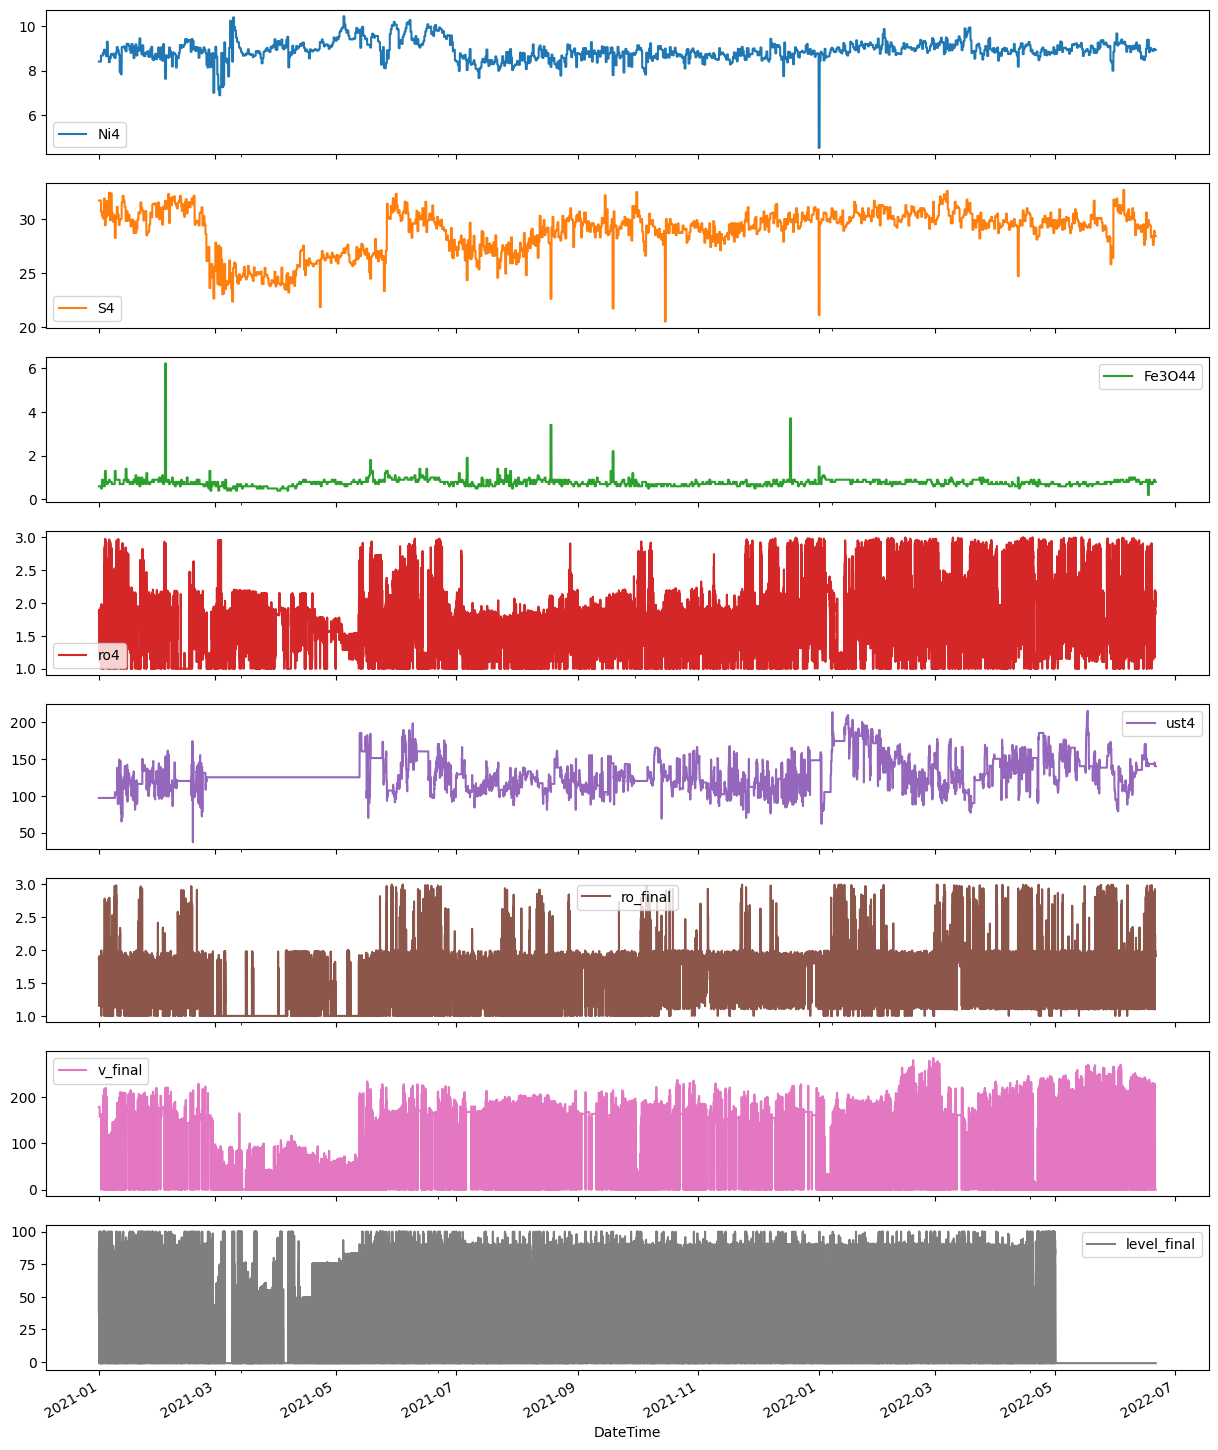

In [10]:
for col in columns_groups:
  data1[columns_groups[col]].plot(subplots=True, figsize=(15, 20), legend='center left')
  plt.show()

Следует отметить, что присутствуют значительные периоды, когда некоторые показатели не менялись продолжительное время (более 12 часов).  
С этим обстоятельством следует бороться, но займемся этим в следующей подзадаче.

Построим боксплоты на предмет выбросов

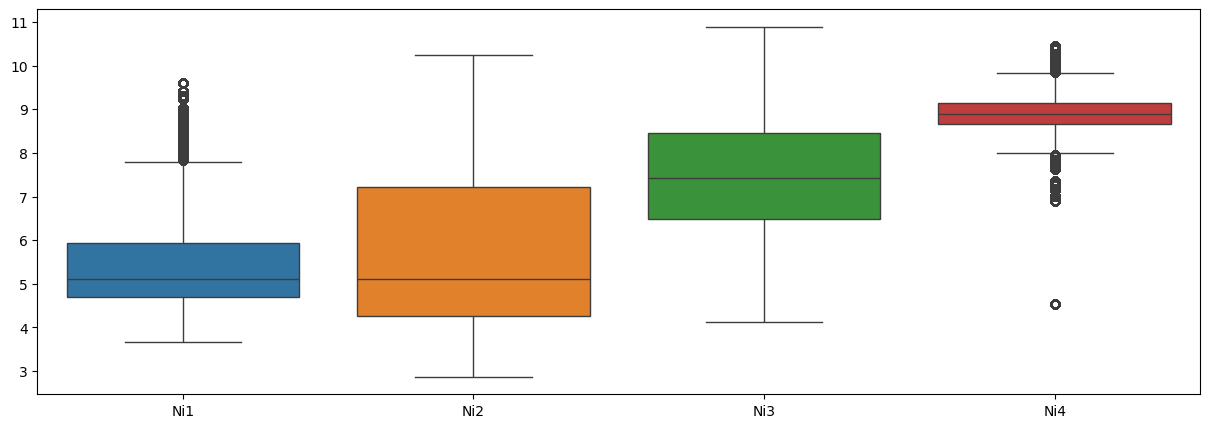

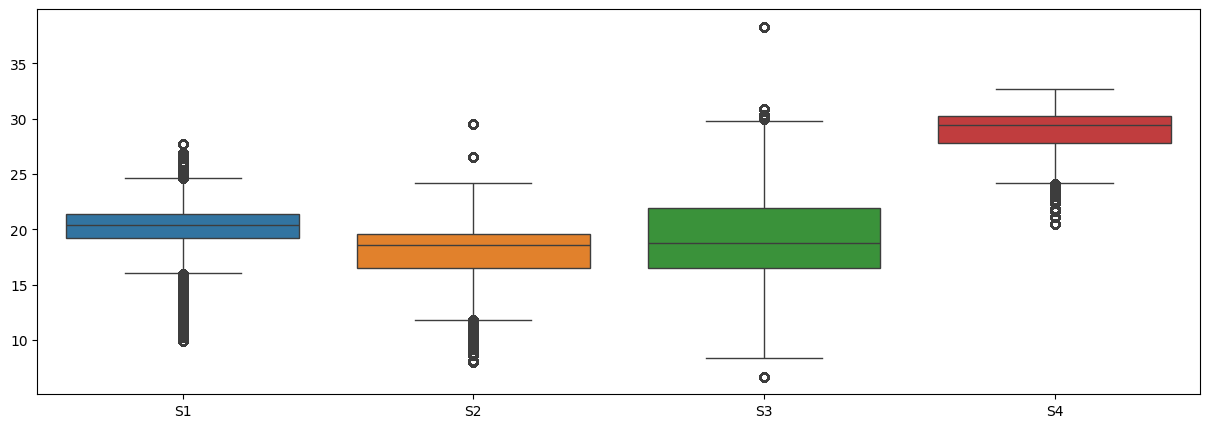

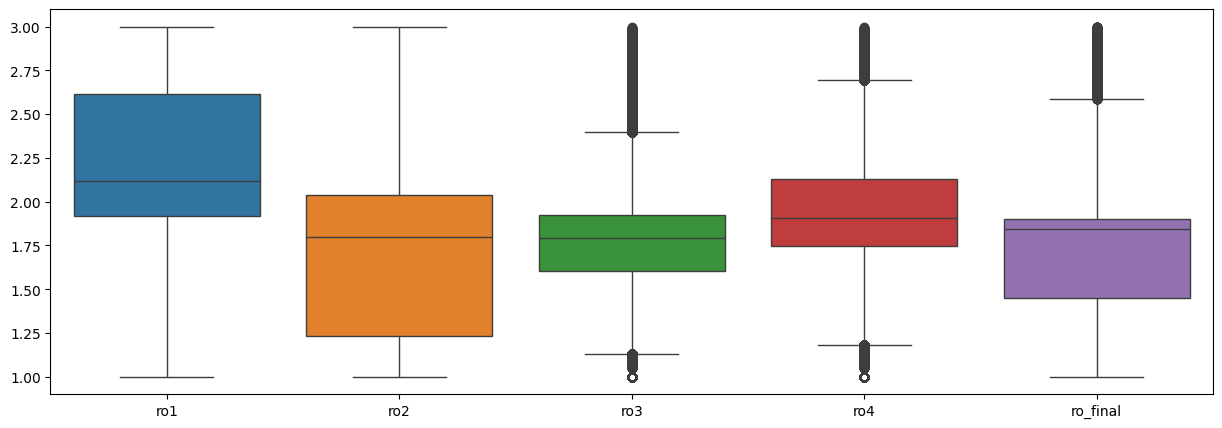

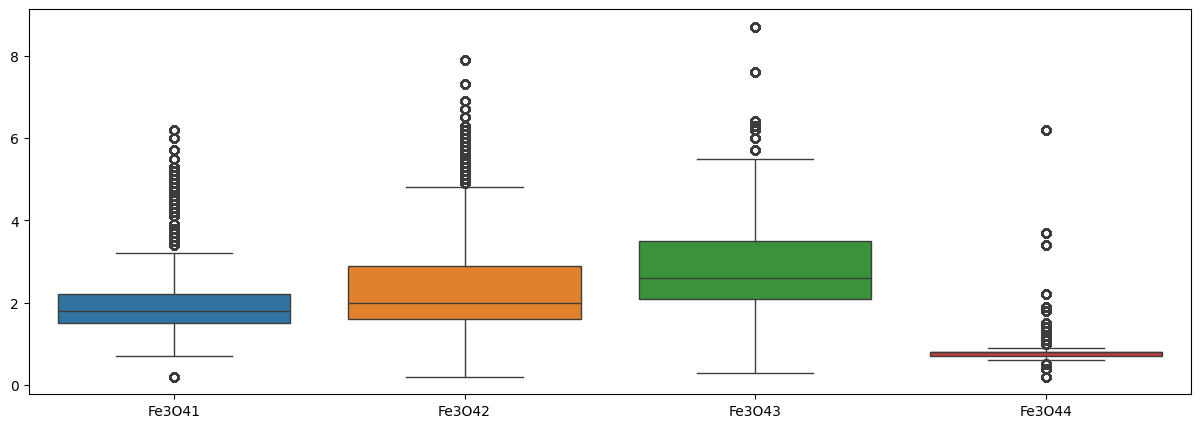

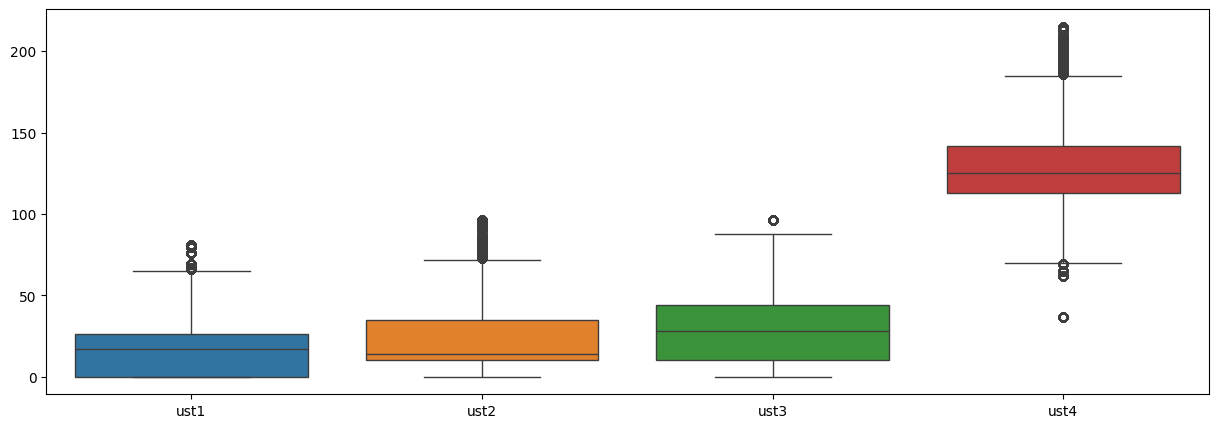

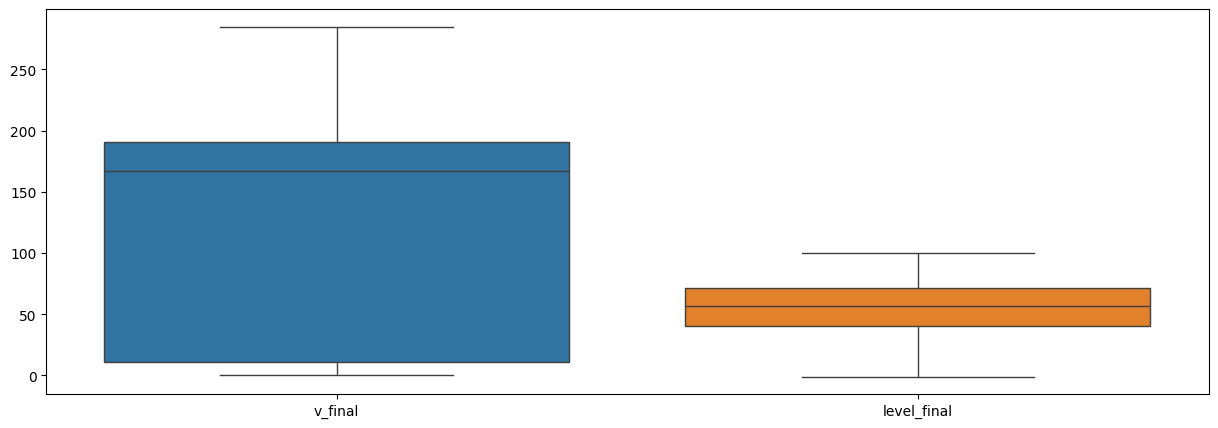

In [11]:
for col in columns_groups_entity:
  fig = plt.figure(figsize = (15,5))
  sns.boxplot(data1.loc[data1.index, columns_groups_entity[col]])
  plt.show()

fig = plt.figure(figsize = (15,5))
sns.boxplot(data1.loc[data1.index, ['v_final', 'level_final']])
plt.show()

Выбросы, как бы, есть, но стоит ли считать их выбросами - вопрос спорный. Нужно анализировать на этапе построения модели.

Проверим на дубликаты (причем сделаем reset_index), иначе - не стоит считать дубликатами.

In [12]:
data1.reset_index()[data1.reset_index().duplicated()]

,DateTime,Ni1,S1,Fe3O41,Ni2,S2,Fe3O42,Ni3,S3,Fe3O43,...,ro2,ro3,ro4,ro_final,ust1,ust2,ust3,ust4,v_final,level_final
18253,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
18254,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
18255,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
18256,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
18257,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681020,2022-04-18 18:38:00,4.48,20.50,1.4,3.57,21.20,1.6,6.45,19.00,2.1,...,2.1404,1.48740,2.3642,1.8465,15.0,32.0,45,152.0,232,87.1307
681022,2022-04-18 18:38:00,4.48,20.50,1.4,3.57,21.20,1.6,6.45,19.00,2.1,...,2.1404,1.48740,2.3642,1.8465,15.0,32.0,45,152.0,232,87.6190
681023,2022-04-18 18:38:00,4.48,20.50,1.4,3.57,21.20,1.6,6.45,19.00,2.1,...,2.1404,1.48740,2.3642,1.8465,15.0,32.0,45,152.0,232,87.6190
681025,2022-04-18 18:38:00,4.48,20.50,1.4,3.57,21.20,1.6,6.45,19.00,2.1,...,2.1404,1.48740,2.3642,1.8465,15.0,32.0,45,152.0,232,88.5714


Получаем 168 строк явно являющихся дубликатами. На этапе построения моделей схлопнем их тем или иным методом.

Рассмотрим еще гистограммы распределения данных, причем в двух вариациях:

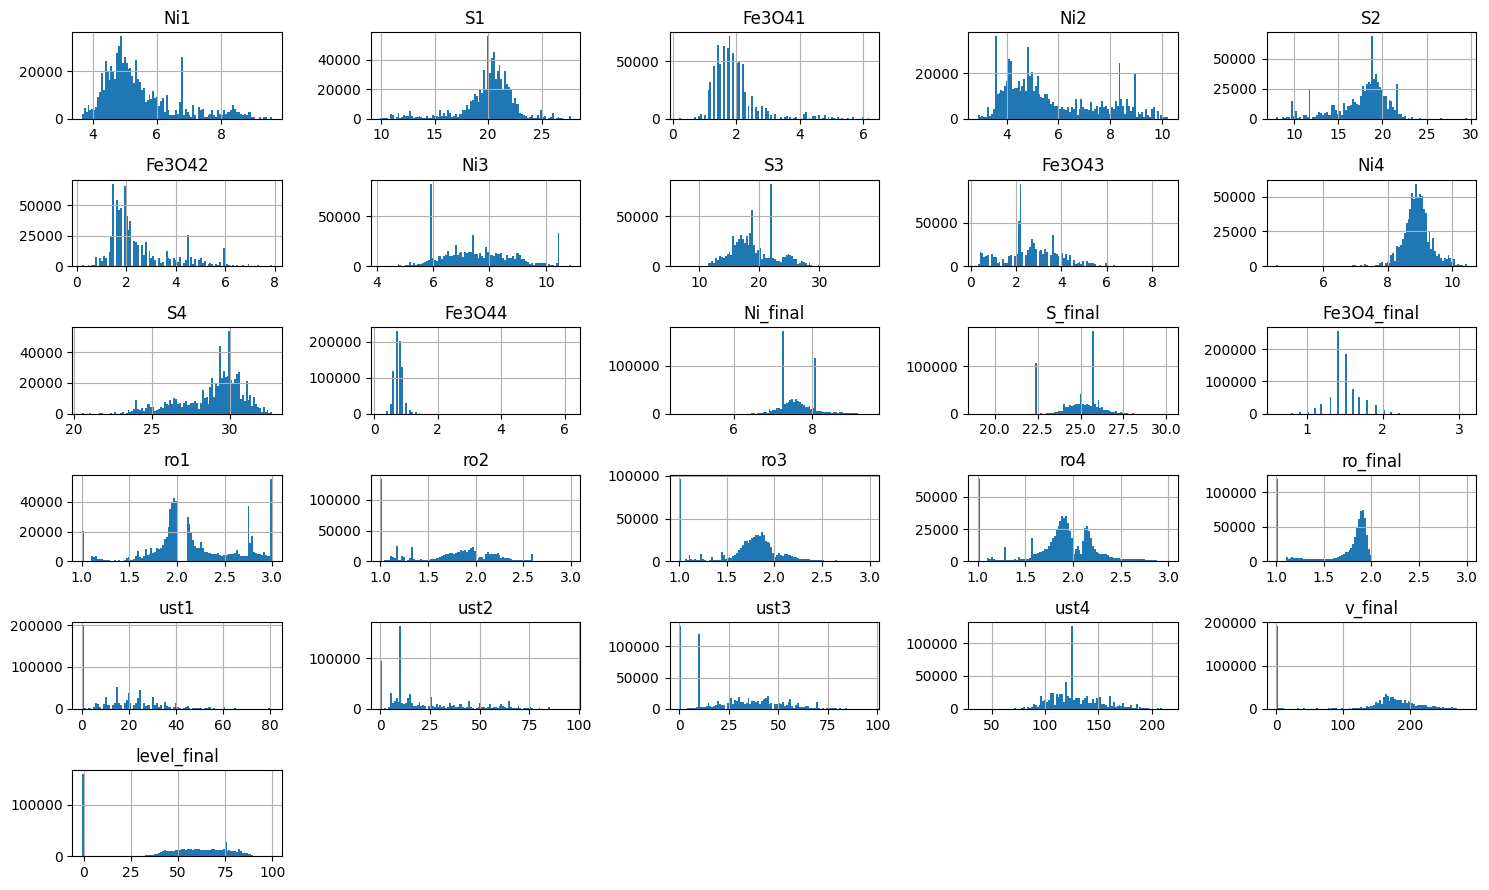

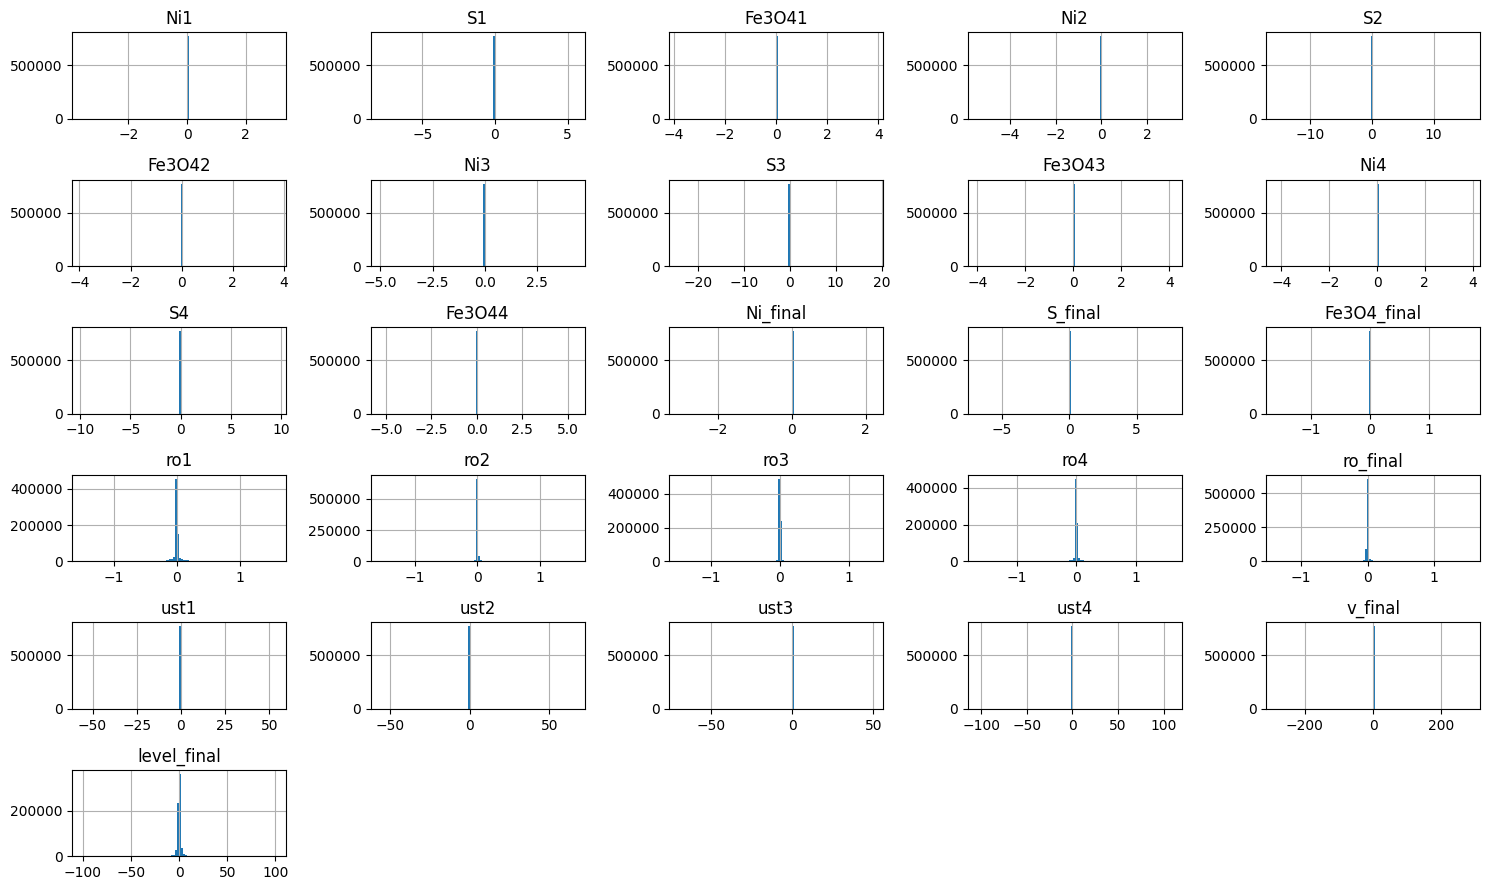

In [13]:
data1.hist(bins=100, figsize=(15, 9))
plt.tight_layout()
plt.show()

(data1 - data1.shift()).hist(bins=100, figsize=(15, 9))
plt.tight_layout()
plt.show()

Простым способом посмотреть распределения приращений не удалось, опять же, оставим этот вопрос на этап моделирования

#### data2

Для data2 результаты будут аналогичными, нет особого смысла проводить EDA повторно, все аномалии будут исправляться на этапе 2

In [14]:
# Код для data2 (потенциальный)

### Выводы

В данных присутствуют:  
1. Несоответствия заданным условиям ($\rho$ больше 2.5)
2. Выбросы (хотя вопрос спорный, неочев)
3. Периоды, когда некоторые показатели не менялись продолжительное время (более 12 часов)
4. Дубликаты  
  
Все это нестрашно, со всем разберемся и победим, но в следующей части выполнения задания.

## Task 2 - physical and mathematical description

### math model 1

$$C_{final,i}=\frac{\sum_{j=1}^{4}(F_j*C_{i,j})}{\sum_{j=1}^{4}F_j}$$
где $C_{final,i}$ - концентрация $i$-го вещества на выходе,  
$F_j$ - поток из $j$-ой емкости (определяемый уставкой $ust_j$),  
$C_{i,j}$ - концентрация $i$-го вещества в $j$-ой емкости

Уравнения для Никеля, Серы и Fe304:
$$Ni_{final}=\frac{F_1*Ni_1 + F_2*Ni_2 + F_3*Ni_3 + F_4*Ni_4}{F_1+F_2+F_3+F_4}$$  
$$S_{final}=\frac{F_1*S_1 + F_2*S_2 + F_3*S_3 + F_4*S_4}{F_1+F_2+F_3+F_4}$$
$$Fe304_{final}=\frac{F_1*Fe304_1 + F_2*Fe304_2 + F_3*Fe304_3 + F_4*Fe304_4}{F_1+F_2+F_3+F_4}$$

<Axes: >

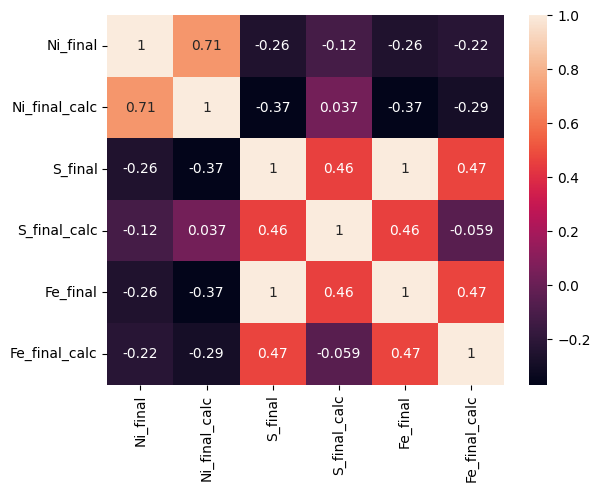

In [13]:
pred_ni = pd.concat([
  data1['Ni_final'],
  (data1['ust1'] * data1['Ni1'] + data1['ust2'] * data1['Ni2'] + \
  data1['ust3'] * data1['Ni3'] + data1['ust4'] * data1['Ni4']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_ni.columns = ['Ni_final', 'Ni_final_calc']

pred_S = pd.concat([
  data1['S_final'],
  (data1['ust1'] * data1['S1'] + data1['ust2'] * data1['S2'] + \
  data1['ust3'] * data1['S3'] + data1['ust4'] * data1['S4']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_S.columns = ['S_final', 'S_final_calc']

pred_Fe = pd.concat([
  data1['S_final'],
  (data1['ust1'] * data1['Fe3O41'] + data1['ust2'] * data1['Fe3O42'] + \
  data1['ust3'] * data1['Fe3O43'] + data1['ust4'] * data1['Fe3O44']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_Fe.columns = ['Fe_final', 'Fe_final_calc']

sns.heatmap(
  pd.concat([
    pred_ni,
    pred_S,
    pred_Fe,
  ], axis=1).corr(),
  annot=True
)

<Axes: xlabel='DateTime'>

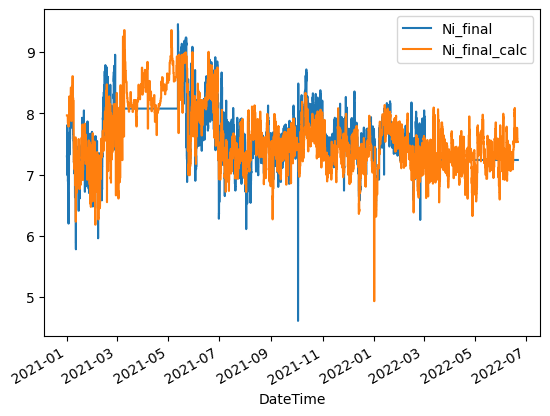

In [14]:
X = pred_ni['Ni_final_calc'].values.reshape(-1, 1)
y = pred_ni['Ni_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_ni.iloc[:, 0], pred_ni.iloc[:, 1] * lr.coef_[0]], axis=1).plot()

<Axes: xlabel='DateTime'>

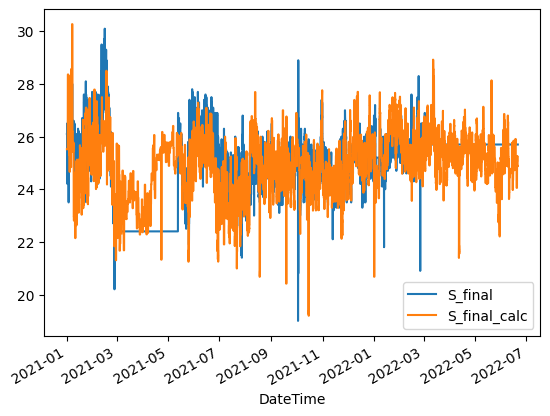

In [15]:
X = pred_S['S_final_calc'].values.reshape(-1, 1)
y = pred_S['S_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_S.iloc[:, 0], pred_S.iloc[:, 1] * lr.coef_[0]], axis=1).plot()

<Axes: xlabel='DateTime'>

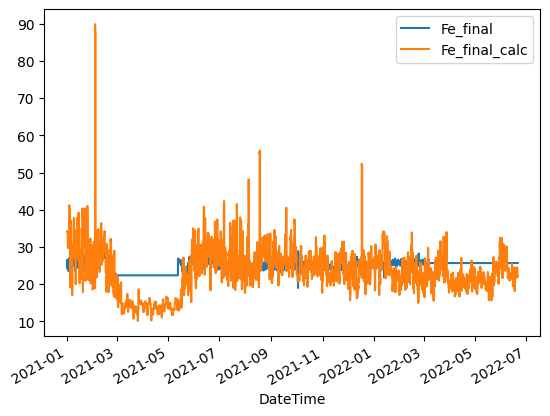

In [16]:
X = pred_Fe['Fe_final_calc'].values.reshape(-1, 1)
y = pred_Fe['Fe_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_Fe.iloc[:, 0], pred_Fe.iloc[:, 1] * lr.coef_[0]], axis=1).plot()

### Второе приближение

In [17]:
columns1 = [f'data1_{col}' for col in data1.columns]
columns2 = [f'data2_{col}' for col in data2.columns]

In [18]:
data1.columns = columns1
data2.columns = columns1
data1 = data1[data1 != data2].ffill().dropna(axis=1)

In [19]:
columns1 = [f'data1_{col}' for col in data1.columns]
columns2 = [f'data2_{col}' for col in data2.columns]

In [20]:
data1.columns = columns1
data2.columns = columns2

In [21]:
data_full = pd.concat([data1, data2], axis=1)
columns_list = list(data_full.columns)
new_columns = []
for col in columns_list:
  new_columns.append(
    col.replace('data1_data1', 'data1').replace('data2_data1', 'data2')
  )
# new_columns

In [22]:
data_full.columns = new_columns
data_full.head(3)

,data1_Ni_final,data1_S_final,data1_ro_final,data1_ust2,data1_ust3,data1_ust4,data1_v_final,data1_level_final,data2_Ni1,data2_S1,...,data2_ro2,data2_ro3,data2_ro4,data2_ro_final,data2_ust1,data2_ust2,data2_ust3,data2_ust4,data2_v_final,data2_level_final
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,7.3,26.1,1.8684,0.0,44.0,97.0,179.0,69.2796,5.45,22.39,...,1.68910,2.0167,1.86565,1.8892,0.0,44.0,23.0,167.0,163,64.9328
2021-01-01 00:01:00,7.3,26.1,1.8752,0.0,44.0,97.0,179.0,69.1331,5.45,22.39,...,1.69955,2.0290,1.86145,1.8896,0.0,44.0,23.0,167.0,163,66.4469
2021-01-01 00:02:00,7.3,26.1,1.8635,0.0,44.0,97.0,179.0,66.7399,5.45,22.39,...,1.69980,2.0453,1.85210,1.8833,0.0,44.0,23.0,167.0,163,68.4982


In [23]:
data_full.columns
target = [
  'data1_Ni_final',
  'data1_S_final',
  'data1_ro_final',
  'data1_v_final',
  'data2_Ni_final',
  'data2_S_final',
  'data2_Fe3O4_final',
  'data2_ro_final',
  'data2_level_final'
]
features = list(set(data_full.columns) - set(target))

In [24]:
new_features = features.copy()
for i in tqdm(range(10)):
  for col in data_full[features]:
    new_features.append(f'lag{i}_{col}')
    data_full[f'lag{i}_{col}'] = data_full[col].shift(i)

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
data_full.head(3)

,data1_Ni_final,data1_S_final,data1_ro_final,data1_ust2,data1_ust3,data1_ust4,data1_v_final,data1_level_final,data2_Ni1,data2_S1,...,lag9_data2_S1,lag9_data1_level_final,lag9_data2_S3,lag9_data2_Ni3,lag9_data2_Ni2,lag9_data1_ust2,lag9_data2_ust1,lag9_data2_Ni1,lag9_data2_Fe3O42,lag9_data2_ust3
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,7.3,26.1,1.8684,0.0,44.0,97.0,179.0,69.2796,5.45,22.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:01:00,7.3,26.1,1.8752,0.0,44.0,97.0,179.0,69.1331,5.45,22.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:02:00,7.3,26.1,1.8635,0.0,44.0,97.0,179.0,66.7399,5.45,22.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data_full[target] = data_full[target].shift(-1)
data_full = data_full.ffill().dropna()

In [27]:
X = data_full[new_features].values
y = data_full[target].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [28]:
lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(x_train, y_train)

LinearRegression(fit_intercept=False, n_jobs=-1)

In [29]:
pd.DataFrame(abs(lr.predict(x_train) - y_train) / np.where(y_train == 0, y_train.mean(), y_train), columns=target).max()

data1_Ni_final          0.599359
data1_S_final           0.299135
data1_ro_final          1.051557
data1_v_final         189.241955
data2_Ni_final          0.378242
data2_S_final           0.230851
data2_Fe3O4_final       1.181250
data2_ro_final          1.173578
data2_level_final    2015.921741
dtype: float64

In [30]:
pd.DataFrame(abs(lr.predict(x_test) - y_test) / np.where(y_test == 0, y_test.mean(), y_test), columns=target).max()

data1_Ni_final         0.596912
data1_S_final          0.297960
data1_ro_final         1.024652
data1_v_final        177.485258
data2_Ni_final         0.378198
data2_S_final          0.230557
data2_Fe3O4_final      1.180196
data2_ro_final         1.083590
data2_level_final    762.254722
dtype: float64

Вывод: линейность не справляется :c

#### Третье приближение

Построим LSTM, на основании существующей модели будем делать оптимизацию.

In [159]:
data1 = pd.read_csv('data/data1.csv', index_col='DateTime')
data2 = pd.read_csv('data/data2.csv', index_col='DateTime')

data1 = data1[(data1 == data2).sum()[(((data1 == data2).sum()) != 772067)].index]

columns1 = list(data1.columns)
columns2 = list(data2.columns)

for col in range(len(columns1)):
  columns1[col] = f'data1_{columns1[col]}'

for col in range(len(columns2)):
  columns2[col] = f'data2_{columns2[col]}'

data1.columns = columns1
data2.columns = columns2

data_full = pd.concat([data1, data2], axis=1)

In [160]:
data_full = data_full[(data_full['data2_ro1'] >= 1.0) & (data_full['data2_ro1'] <= 2.5) &
          (data_full['data2_ro2'] >= 1.0) & (data_full['data2_ro2'] <= 2.5) &
          (data_full['data2_ro3'] >= 1.0) & (data_full['data2_ro3'] <= 2.5) &
          (data_full['data2_ro4'] >= 1.0) & (data_full['data2_ro4'] <= 2.5)]

In [33]:
# data_full = data_full[(data_full['data2_level_final'].pct_change() != 0) & (data_full['data2_level_final'] > 0)]

array([<Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='Da

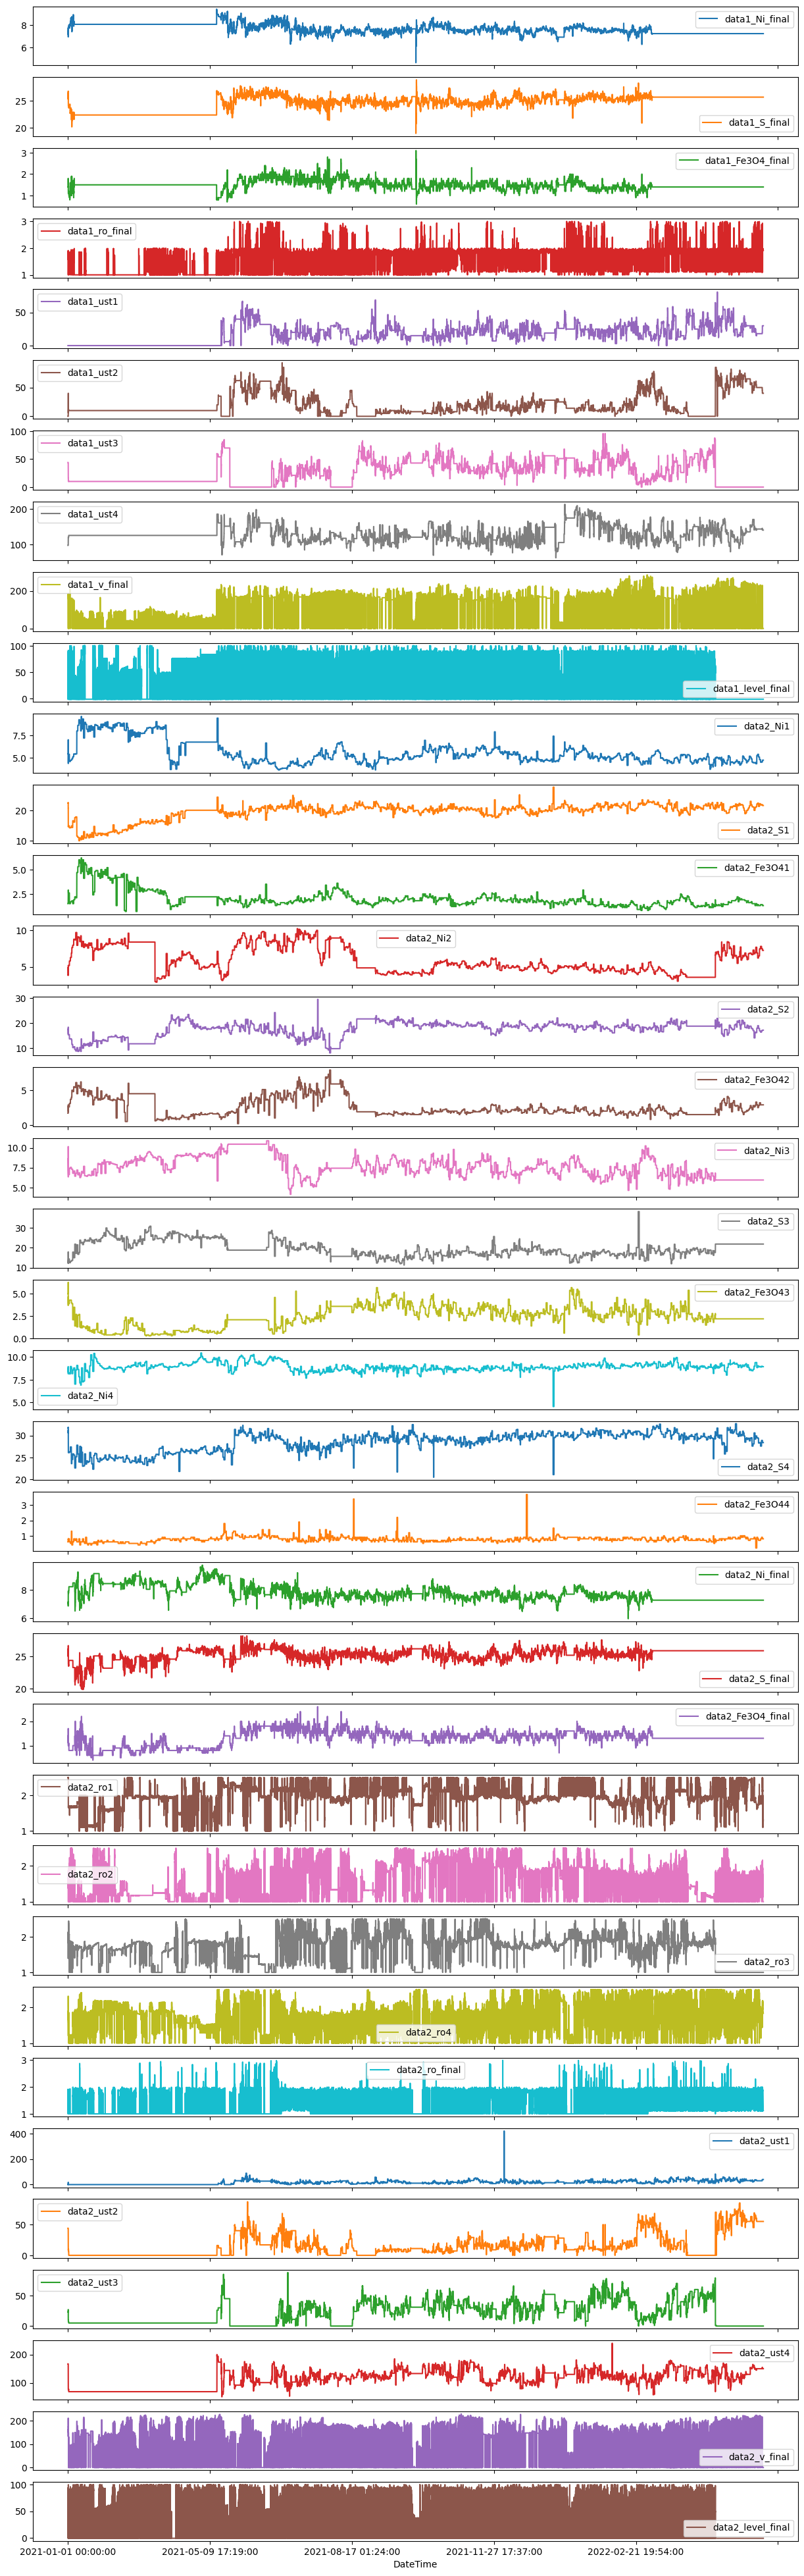

In [141]:
data_full.plot(subplots=True, figsize=(15, 50))

In [161]:
# Преобразуем данные в NumPy массивы для ускорения
data_full_values = data_full.values
target_values = data_full[target].values

# Используем списки пониманий для создания all_x и all_y
all_x = np.array([data_full_values[i:i+50] for i in tqdm(range(len(data_full) - 51))])
all_y = np.array([target_values[i+51] for i in tqdm(range(len(data_full) - 51))])

  0%|          | 0/489657 [00:00<?, ?it/s]

  0%|          | 0/489657 [00:00<?, ?it/s]

In [162]:
x, x_final = all_x[:-25000], all_x[-25000:]
y, y_final = all_y[:-25000], all_y[-25000:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [163]:
x_train.shape, x_test.shape, x_final.shape

((371725, 50, 36), (92932, 50, 36), (25000, 50, 36))

In [164]:
y_train.shape, y_test.shape, y_final.shape

((371725, 9), (92932, 9), (25000, 9))

In [165]:
x_train = torch.Tensor(x_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.Tensor(x_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

x_final = torch.Tensor(x_final)
y_final = torch.tensor(y_final, dtype=torch.float32)

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of x_train:", x_test.shape)
print("Shape of y_train:", y_test.shape)

print("Shape of x_train:", x_final.shape)
print("Shape of y_train:", y_final.shape)

Shape of x_train: torch.Size([371725, 50, 36])
Shape of y_train: torch.Size([371725, 9])
Shape of x_train: torch.Size([92932, 50, 36])
Shape of y_train: torch.Size([92932, 9])
Shape of x_train: torch.Size([25000, 50, 36])
Shape of y_train: torch.Size([25000, 9])


In [166]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Создаем dataset и dataloader
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)
final_dataset = TimeSeriesDataset(x_final, y_final)

batch_size = 64  # Выбираем подходящий размер батча

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=False)

In [167]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

x_final = x_final.to(device)
y_final = y_final.to(device)

In [174]:
# Создание простой модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Используем последнее значение из последовательности
        return out

# Гиперпараметры
input_size = x_train.shape[2] 
hidden_size = 50  
output_size = y_train.shape[1]
num_layers = 1  
learning_rate = 0.0001
num_epochs = 300

In [175]:
# Инициализация модели, функции потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            running_test_loss = 0.0
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_test_pred = model(x_batch).squeeze()
                test_loss = criterion(y_test_pred, y_batch)
                running_test_loss += test_loss.item()

            test_loss = running_test_loss / len(test_loader)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(10, num_epochs+1, 5), train_losses, label='Train Loss')
plt.scatter(range(10, num_epochs+1, 5), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [5/300], Train Loss: 254.7886, Test Loss: 514.8396
Epoch [10/300], Train Loss: 68.1405, Test Loss: 138.1687
Epoch [15/300], Train Loss: 65.1297, Test Loss: 121.2798
Epoch [20/300], Train Loss: 64.0546, Test Loss: 114.3888
Epoch [25/300], Train Loss: 63.3562, Test Loss: 110.6618
Epoch [30/300], Train Loss: 62.7750, Test Loss: 108.9668
Epoch [35/300], Train Loss: 62.3309, Test Loss: 107.6332
Epoch [40/300], Train Loss: 61.8004, Test Loss: 107.7445
Epoch [45/300], Train Loss: 61.2737, Test Loss: 104.8632
Epoch [50/300], Train Loss: 60.7156, Test Loss: 103.6688
Epoch [55/300], Train Loss: 60.3340, Test Loss: 103.7567
Epoch [60/300], Train Loss: 60.0260, Test Loss: 100.9482
Epoch [65/300], Train Loss: 59.7571, Test Loss: 103.1211
Epoch [70/300], Train Loss: 59.5455, Test Loss: 102.4431
Epoch [75/300], Train Loss: 59.3482, Test Loss: 101.9210
Epoch [80/300], Train Loss: 59.3025, Test Loss: 104.7874
Epoch [85/300], Train Loss: 58.8648, Test Loss: 104.4936
Epoch [90/300], Train Loss: 58.

KeyboardInterrupt: 

In [176]:
model.eval()
with torch.no_grad():
  final_predictions = model(x_final).squeeze().cpu().numpy()

pd.DataFrame(abs(final_predictions - y_final.cpu().numpy()), columns=target).describe()

,data1_Ni_final,data1_S_final,data1_ro_final,data1_v_final,data2_Ni_final,data2_S_final,data2_Fe3O4_final,data2_ro_final,data2_level_final
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.479015,1.360088,0.274562,21.236458,0.445249,1.237085,0.158785,0.165364,20.752377
std,0.372567,1.438279,0.189785,25.734610,0.364911,1.305299,0.132342,0.160380,8.572449
min,0.000192,0.000004,0.000030,0.000320,0.000061,0.000360,0.000022,0.000014,0.008980
25%,0.320131,0.446708,0.157735,7.732384,0.289570,0.389690,0.065019,0.058382,16.557127
50%,0.454032,0.992743,0.232421,15.311152,0.425062,1.007556,0.135655,0.122751,22.153032
75%,0.606318,1.783525,0.334280,26.178120,0.551653,1.574688,0.200155,0.206870,25.375381
max,4.270439,11.811368,1.502468,287.918671,4.360724,11.908161,0.809596,1.179959,51.115360


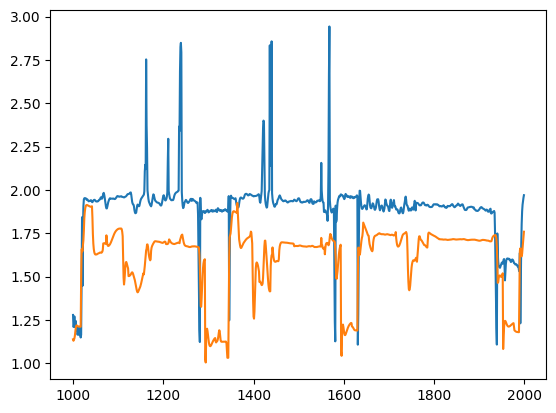

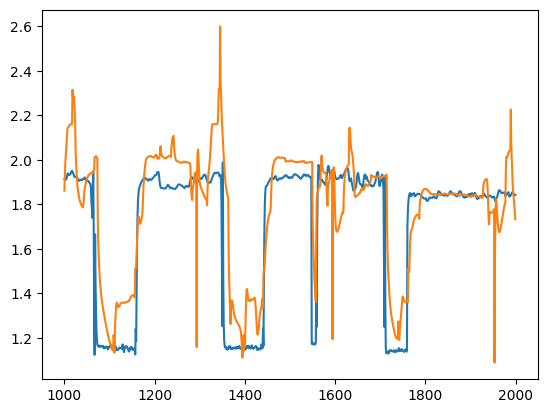

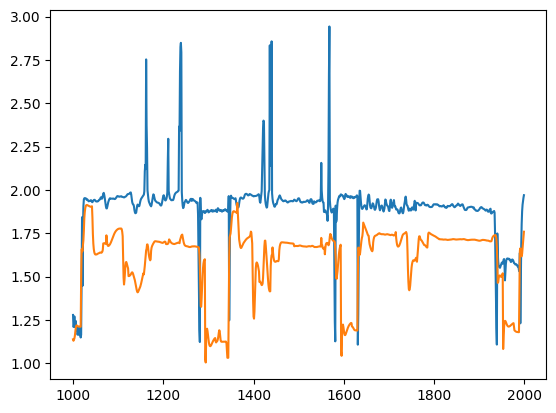

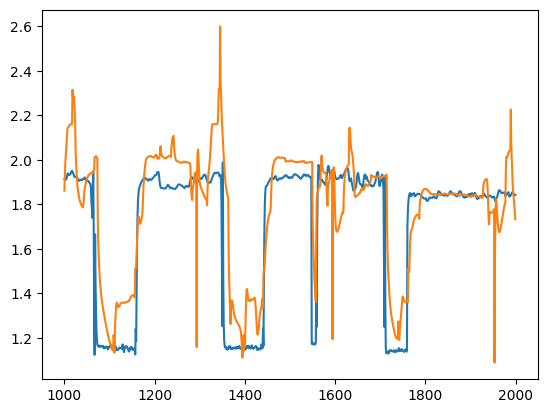

In [177]:
pd.DataFrame(y_final.cpu().numpy(), columns=target)['data1_ro_final'][1000:2000].plot()
pd.DataFrame(final_predictions, columns=target)['data1_ro_final'][1000:2000].plot()
plt.show()

pd.DataFrame(y_final.cpu().numpy(), columns=target)['data2_ro_final'][1000:2000].plot()
pd.DataFrame(final_predictions, columns=target)['data2_ro_final'][1000:2000].plot()
plt.show()

pd.DataFrame(y_final.cpu().numpy(), columns=target)['data1_ro_final'][1000:2000].plot()
pd.DataFrame(final_predictions, columns=target)['data1_ro_final'][1000:2000].plot()
plt.show()

pd.DataFrame(y_final.cpu().numpy(), columns=target)['data2_ro_final'][1000:2000].plot()
pd.DataFrame(final_predictions, columns=target)['data2_ro_final'][1000:2000].plot()
plt.show()

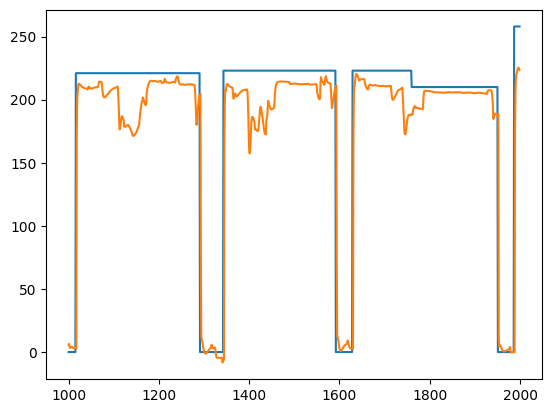

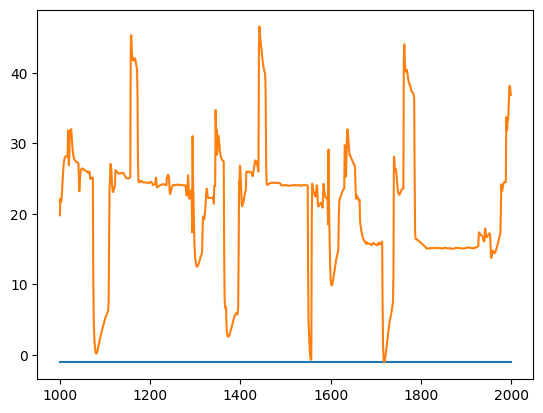

In [178]:
pd.DataFrame(y_final.cpu().numpy(), columns=target)['data1_v_final'][1000:2000].plot()
pd.DataFrame(final_predictions, columns=target)['data1_v_final'][1000:2000].plot()
plt.show()

pd.DataFrame(y_final.cpu().numpy(), columns=target)['data2_level_final'][1000:2000].plot()
pd.DataFrame(final_predictions, columns=target)['data2_level_final'][1000:2000].plot()
plt.show()

Выводы по задаче 2:
1. Линейная регрессия вполне нормально себя проявляет
2. Если поэксперементировать с нелинейными зависимостями, можно создать +- интерпретируемую модель
3. LSTM так же показывает себя хорошо, но мощностей, отнюдь, не хватает
4. хуже всего пректится v_final, нужно подробнее поковырять эти данные
5. можно предложить строить отдельную модель непосредственно для v_final, которая, потенциально,  
будет работать лучше, взять больший временной лаг

Идея:
Уставки после LSTM в линейный слой  
2 входа (история + уставки)  

Приведение к каноническому виду

UPD:  
**Модель требует дообучения**  
на сервере подъемно, в рамках учебной задачи на своем ноуте - едва ли

### Task3

Возникает вопрос, а как при помощи полученной модели решить задачу заказчика?  
Нейросеть дает возможность при помощи backpropagation получить вектор, который нужно "Вводить" в сеть,  
чтобы получить заданный выход, а нам как раз это и нужно!  
  
Попробуем реализовать описанный подход:

In [204]:
# Параметры модели
input_size = 36
hidden_size = 20
output_size = 9
num_layers = 1


# Целевое значение выхода (пример)
desired_output_value = [0.1] * output_size  # Замените на ваше целевое значение
target_value = torch.tensor([desired_output_value], requires_grad=False).to(device)

# Начальный входной вектор (пример)
sequence_length = 50  # Длина последовательности
batch_size = 1       # Для простоты используем batch_size = 1
input_vector = torch.randn((batch_size, sequence_length, input_size), requires_grad=True, device=device)

# Оптимизатор
optimizer = optim.Adam([input_vector], lr=0.01)

# Функция потерь
loss_fn = nn.MSELoss()

# Обратное распространение и оптимизация
num_steps = 10 ** 4  # Замените на желаемое количество шагов
for step in range(num_steps):
    model.train()  # Переключение в режим обучения
    
    optimizer.zero_grad()
    output = model(input_vector)
    loss = loss_fn(output, target_value)
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print(f'Step {step}, Loss: {loss.item()}')

model.eval()  # Возвращение в режим оценки

# После оптимизации input_vector должен приближаться к нужному вектору
optimized_input = input_vector.detach().cpu().numpy()

Step 0, Loss: 64.30912017822266
Step 100, Loss: 2.110712766647339
Step 200, Loss: 1.0190366506576538
Step 300, Loss: 0.3161425292491913
Step 400, Loss: 0.24718986451625824
Step 500, Loss: 0.22585535049438477
Step 600, Loss: 0.20444689691066742
Step 700, Loss: 0.18318066000938416
Step 800, Loss: 0.16263481974601746
Step 900, Loss: 0.143449068069458
Step 1000, Loss: 0.12602120637893677
Step 1100, Loss: 0.11063388735055923
Step 1200, Loss: 0.09725776314735413
Step 1300, Loss: 0.08557622134685516
Step 1400, Loss: 0.0753602534532547
Step 1500, Loss: 0.06618969887495041
Step 1600, Loss: 0.05784796550869942
Step 1700, Loss: 0.050239451229572296
Step 1800, Loss: 0.04333863779902458
Step 1900, Loss: 0.03719387948513031
Step 2000, Loss: 0.03184811398386955
Step 2100, Loss: 0.027215713635087013
Step 2200, Loss: 0.023258784785866737
Step 2300, Loss: 0.01989525929093361
Step 2400, Loss: 0.017040599137544632
Step 2500, Loss: 0.01461866032332182
Step 2600, Loss: 0.012571687810122967
Step 2700, Loss: 

In [205]:
optimized_input

array([[[ 0.37923548,  0.06465966, -1.2583023 , ...,  1.1063815 ,
         -1.2930995 , -0.39284545],
        [ 1.4982173 ,  0.02540645, -0.340428  , ..., -0.18929845,
         -0.08129292,  1.7786345 ],
        [-1.2060436 ,  0.98052   ,  0.31860572, ..., -0.91360795,
         -0.20589988, -1.5706536 ],
        ...,
        [-1.2719647 , -1.0039397 ,  0.78254473, ..., -2.1979566 ,
          0.20200542, -0.3091567 ],
        [-0.06265323,  1.5591508 ,  1.6855121 , ...,  0.5993015 ,
          1.1024822 , -0.41039255],
        [ 1.3877044 ,  0.27285194,  2.1532445 , ...,  1.1734858 ,
         -0.30765   ,  1.3770785 ]]], dtype=float32)

Докрутив оптимизацию (поскольку в заданном input'e большая часть значений известна)  
А также, докрутив саму LSTM (дообучив, поигравшись с глубиной и тп) можно запускать такое решение в прод, как полноценное